In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lr
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

### Часть 1. Подготовливаем данные

In [2]:
df = pd.read_csv('train.csv', sep=',')
df_init = pd.read_csv('train.csv', sep=',')
scaler=MinMaxScaler()

# Удаляет 
def drop_healthcare(df):
    # df['Healthcare_1']=df['Healthcare_1'].fillna(0)
    df = df.drop(['Healthcare_1'], axis=1)
    return df

# Данные о размерах комнат
def prep_rooms(df):
    df.loc[df['Rooms']==10,'Rooms']=2
    df.loc[df['Rooms']==17,'Rooms']=2
    df.loc[df['Rooms']==6,'Rooms']=2
    df.loc[df['Rooms']==19,'Rooms']=1
    df.loc[df['Rooms']==0,'Rooms']=1
    return df

def prep_floor(df):
    df.loc[df['Floor']>df['HouseFloor'],'HouseFloor']=df['Floor']
    return df
 
def prep_house_year(df):
    df.loc[df['HouseYear']==4968, 'HouseYear']=1968
    df.loc[df['HouseYear']==20052011,'HouseYear']=2008
    return df

# Жилая площадь не может превышать общей площади квартиры, приравняем их, 
# сглаживаем выбросы по верхнему и нижнему интерквартильному размаху
def prep_lifesquare(df, source_df):    
    df['LifeSquare']=df['LifeSquare'].fillna(source_df['LifeSquare'].mean())      
    df.loc[df['LifeSquare']>np.percentile(df['LifeSquare'],75),'LifeSquare']=np.percentile(df['LifeSquare'],75)
    df.loc[df['LifeSquare']<np.percentile(df['LifeSquare'],25),'LifeSquare']=np.percentile(df['LifeSquare'],25)
    df.loc[df['LifeSquare']>df['Square'],'LifeSquare']=df['Square']
    df['LifeSquare']=df['Square']-df['KitchenSquare']
    
    return df

def prep_kitchensquare(df):
    df.loc[df['KitchenSquare']<6,'KitchenSquare']=np.percentile(df['KitchenSquare'],50)
    df.loc[df['KitchenSquare']>np.percentile(df['KitchenSquare'],75),'KitchenSquare']=np.percentile(df['KitchenSquare'],75)
    df.loc[df['KitchenSquare']<np.percentile(df['KitchenSquare'],25),'KitchenSquare']=np.percentile(df['KitchenSquare'],25)
    return df
    
# Цены квартир наиболее высоко коррелируют с площадью и количеством комнат,
# Используем функцию для сглаживания выбросов по верхнему и нижнему интерквартильному размаху
def prep_square(df):
    for i in range(1, df.Rooms.max().astype('int64')+1):
        df.loc[(df['Rooms']==i)&(df['Square']>np.percentile(df.loc[df['Rooms']==i,'Square'],75)),'Square'] \
                                =(np.percentile(df.loc[df['Rooms']==i,'Square'],75))
        df.loc[(df['Rooms']==i)&(df['Square']<np.percentile(df.loc[df['Rooms']==i,'Square'],25)),'Square'] \
                                =(np.percentile(df.loc[df['Rooms']==i,'Square'],25))
    return df

def prep_social(df):
    df = pd.get_dummies(df)
    data_scaled=scaler.fit_transform(df.loc[:,['Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1']])
    #df['Comfort']=data_scaled['Ecology_1']+data_scaled['Social_1']+data_scaled['Social_2']+ \
    #       data_scaled['Social_3']+data_scaled['Helthcare_2']+data_scaled['Shops_1']    
    return df

def prep_ex_rooms(df):
    for i in range(1, df.Rooms.max().astype('int64')+1):
        df.loc[(df['Rooms']==i)&(df['Price']>np.percentile(df.loc[df['Rooms']==i,'Price'],75)),'Price'] \
                                =(np.percentile(df.loc[df['Rooms']==i,'Price'],75))
        df.loc[(df['Rooms']==i)&(df['Price']<np.percentile(df.loc[df['Rooms']==i,'Price'],25)),'Price'] \
                                =(np.percentile(df.loc[df['Rooms']==i,'Price'],25))
    return df 

# Группирует показатели, отвечающие за экологию и инфраструктуру района с помощью TSNE
def prep_infrastructure(df):
    tsne = TSNE(n_components=1, learning_rate=150, random_state=100)
    
    infra_scaled = scaler.fit_transform(df.loc[:,['Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1']])
    infra_tsne = tsne.fit_transform(infra_scaled)
    infra_tsne=pd.DataFrame(infra_tsne)
    df['Infrastructure']=infra_tsne
    return df

df = drop_healthcare(df)
df = prep_rooms(df)
df = prep_floor(df)
df = prep_kitchensquare(df)
df = prep_house_year(df)
df = prep_social(df)
df = prep_lifesquare(df, df)
df = prep_square(df)
df = prep_ex_rooms(df)
df = prep_infrastructure(df)

Наиболее кореллированные параметры в модели

In [3]:
a = df.corr()
high_corr = a.loc[a['Price']>abs(0.3),'Price']
high_corr

Rooms         0.822434
Square        0.804290
LifeSquare    0.611520
Price         1.000000
Name: Price, dtype: float64

Основные зависимости датасета

<function matplotlib.pyplot.show(*args, **kw)>

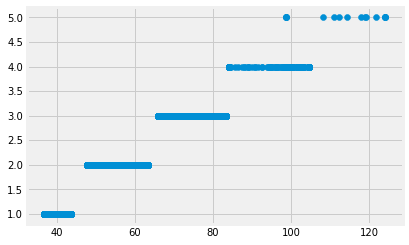

In [4]:
plt.scatter(df['Square'], df['Rooms'])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

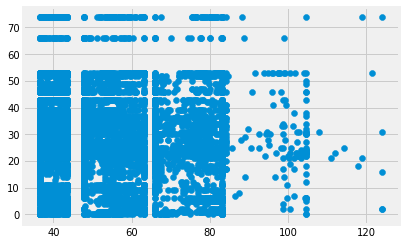

In [5]:
plt.scatter(df['Square'], df['Social_1'])
plt.show

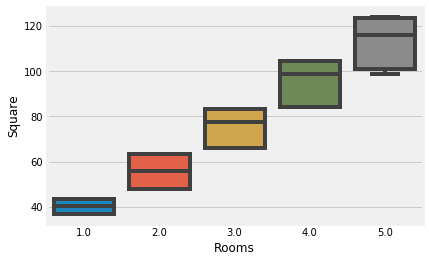

In [6]:
sns.boxplot(x=df['Rooms'],y=df['Square'])

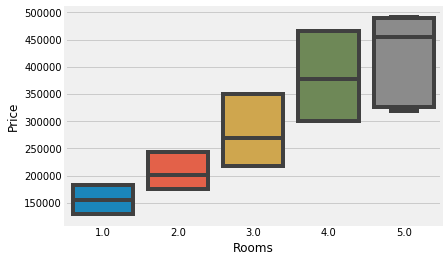

In [7]:
sns.boxplot(x=df['Rooms'],y=df['Price'])

Смотрим плотность распределения данных о комнатах и площади по цене

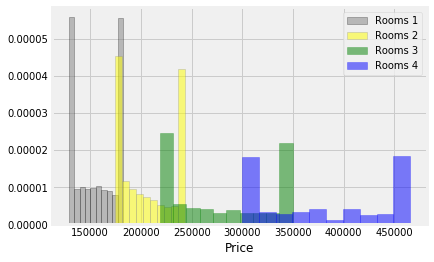

In [8]:
d1 = df.loc[df['Rooms'] == 1, 'Price']
d2 = df.loc[df['Rooms'] == 2, 'Price']
d3 = df.loc[df['Rooms'] == 3, 'Price']
d4 = df.loc[df['Rooms'] == 4, 'Price']

opacity = 0.5
n_groups = 10

rooms_1 = plt.hist(d1, bins=n_groups, ec='black',
color='gray',
alpha=opacity,
label = 'Rooms 1',
density=1)

rooms_2 = plt.hist(d2, bins=n_groups, ec='gray',
color='yellow',
alpha=opacity,
label = 'Rooms 2',
density=1)

rooms_3 = plt.hist(d3, bins=n_groups, ec='green',
color='green',
alpha=opacity,
label = 'Rooms 3',
density=1)

rooms_4 = plt.hist(d4, bins=n_groups, ec='blue',
color='blue',
alpha=opacity,
label = 'Rooms 4',
density=1)

# plt.axis([-35, 5, 0, 0.25])
plt.xlabel('Price')
plt.legend()

plt.show()

In [9]:
# Разбиваем датасет, на тестовые и тренеровочные данные 
train,valid=train_test_split(df,test_size=0.3, random_state=42)
scaler=MinMaxScaler()
train_scaled=scaler.fit_transform(train.loc[:,['Infrastructure', 'DistrictId']])
model_cluster=AgglomerativeClustering(n_clusters=4)
train['Comfort']=model_cluster.fit_predict(train_scaled)

Результат определения количества кластеров

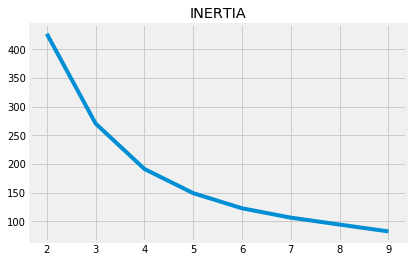

In [10]:
inertia_arr=[]
for i in range(2,10):
    temp_model=KMeans(n_clusters=i,random_state=100)
    temp_model.fit(train_scaled)
    temp_inertia=temp_model.inertia_
    # print(temp_inertia)
    inertia_arr.append(temp_inertia)
plt.plot([i for i in range(2,10) ],inertia_arr)
plt.title('INERTIA')
plt.show()

Результат кластерного распределения

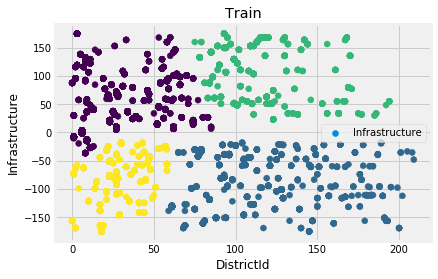

In [11]:
plt.scatter(train['DistrictId'],train['Infrastructure'],c=train['Comfort'])
plt.xlabel('DistrictId')
plt.ylabel('Infrastructure')
plt.title('Train')
plt.legend()
plt.show()

In [12]:
knn=KNeighborsClassifier(n_neighbors=4)
knn.fit(train_scaled,train['Comfort'])
valid_scaled=scaler.transform(valid.loc[:,['Infrastructure', 'DistrictId']])
valid['Comfort']=knn.predict(valid_scaled)

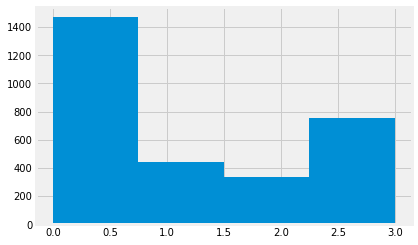

In [13]:
valid['Comfort'].hist(bins=4)

In [14]:
# Создает dummy переменные на основе кластеров
def dummies(df,comfort='Comfort'):
    df['Comfort']=df['Comfort'].astype(object)
    df=pd.get_dummies(df)
    return df
train=dummies(train)
valid=dummies(valid)

In [15]:
valid.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Infrastructure,Comfort_0,Comfort_1,Comfort_2,Comfort_3
6252,3702,21,2.0,48.812195,42.812195,6.0,5,5.0,1963,0.034331,...,1,0,1,0,1,-31.992798,0,0,0,1
4684,12848,61,3.0,81.103039,73.103039,8.0,4,4.0,1960,0.298205,...,1,0,1,0,1,57.162144,1,0,0,0
1731,2239,6,3.0,82.882978,76.882978,6.0,8,17.0,1977,0.243205,...,1,0,1,0,1,-1.147033,1,0,0,0
4742,15611,23,1.0,36.705076,27.863324,6.0,5,5.0,1977,0.034656,...,1,0,1,0,1,-50.159458,0,0,0,1
4521,5634,52,1.0,43.095135,37.095135,6.0,10,17.0,1977,0.371149,...,1,0,1,0,1,14.099679,1,0,0,0


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 27 columns):
Id                7000 non-null int64
DistrictId        7000 non-null int64
Rooms             7000 non-null float64
Square            7000 non-null float64
LifeSquare        7000 non-null float64
KitchenSquare     7000 non-null float64
Floor             7000 non-null int64
HouseFloor        7000 non-null float64
HouseYear         7000 non-null int64
Ecology_1         7000 non-null float64
Social_1          7000 non-null int64
Social_2          7000 non-null int64
Social_3          7000 non-null int64
Helthcare_2       7000 non-null int64
Shops_1           7000 non-null int64
Price             7000 non-null float64
Ecology_2_A       7000 non-null uint8
Ecology_2_B       7000 non-null uint8
Ecology_3_A       7000 non-null uint8
Ecology_3_B       7000 non-null uint8
Shops_2_A         7000 non-null uint8
Shops_2_B         7000 non-null uint8
Infrastructure    7000 non-null float32


In [17]:
feats=train.columns.drop('Price')
feats

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'Ecology_2_A', 'Ecology_2_B',
       'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B',
       'Infrastructure', 'Comfort_0', 'Comfort_1', 'Comfort_2', 'Comfort_3'],
      dtype='object')

### Часть 2. Обучаем прогнозные модели на тестовых данных

#### Модель. Линейная регрессия

In [18]:
model1=lr()
X_train = train.loc[:,feats]
X_test = valid.loc[:,feats]
y_train = train['Price']
y_test = valid['Price']

model1.fit(X_train,y_train)
y_pred = model1.predict(X_test)
print(f"r2_score: {r2_score(y_test, y_pred)}")
print(f"mse: {mse(y_test,y_pred)}")

r2_score: 0.7858383268668329
mse: 847134062.436827


#### Нормализуем данные и снова используем линейную модель

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feats)

X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feats)
model_12 = lr()
model_12.fit(X_train_scaled, y_train)
y_pred_12 = model_12.predict(X_test_scaled)
print(f"r2_score: {r2_score(y_test, y_pred_12)}")
print(f"mse: {mse(y_test,y_pred_12)}")

r2_score: 0.7857770569601636
mse: 847376420.5776768


#### Сравним с Lasso

In [20]:
model_13 = Lasso(alpha=0.03)
model_13.fit(X_train_scaled, y_train)
y_pred_2 = model_13.predict(X_test_scaled)
print(f"r2_score: {r2_score(y_test, y_pred_2)}")

r2_score: 0.7857723352239583


#### Модель. Случайный лес

#### Проведем подбор лучших параметров модели

In [21]:
parameters = {
    'n_estimators': [150, 200, 250],
    'max_features': np.arange(5, 15),
    'max_depth': np.arange(5, 25),
}

clf = GridSearchCV(
    estimator=rf(random_state=42),
    param_grid=parameters,
    scoring='r2',
    cv=5,
)

In [22]:
# Крайне долгая операция (порядка 2-х часов), профит составил около 0.3% (0.003)
clf.fit(X_train, y_train)
y_pred_3 = clf.predict(X_test)
r2_score(y_test, y_pred_3) 

KeyboardInterrupt: 

In [23]:
clf.best_params_

{'max_depth': 16, 'max_features': 6, 'n_estimators': 200}

#### Строим модель случайного леса с лучшими подобранными параметрами

In [23]:
model_2 = rf(n_estimators=200,max_depth=16, max_features=6, random_state=42, n_jobs=-1)
model_2.fit(train.loc[:,feats],train['Price'])

y_pred_2=model_2.predict(valid.loc[:,feats])

print(f"r2_score: {r2_score(valid['Price'], y_pred_2)}")
print(f"mse: {mse(valid['Price'], y_pred_2)}")

r2_score: 0.8864676179464335
mse: 449086648.51233286


In [26]:
# Смотрим наиболее важные параметры 

feature_importance = model_2.feature_importances_
idx = np.argsort(feature_importance)
sorted_idx = np.flipud(idx)

check_test = pd.DataFrame({
    "Признак": feats[sorted_idx],
    "Значимость": feature_importance[sorted_idx]
})
check_test.head()

,Признак,Значимость
0,Rooms,0.276105
1,Square,0.266396
2,LifeSquare,0.172802
3,Social_2,0.040767
4,Social_1,0.038636


### Используем модель `model_2`, показавшую наилучшие результатаы 

### Часть 3. Применяем модели к реальным данным

In [27]:
test=pd.read_csv('test.csv')

test = drop_healthcare(test)
test = prep_rooms(test)
test = prep_floor(test)
test = prep_kitchensquare(test)
test = prep_house_year(test)
test = prep_social(test)
test = prep_lifesquare(test, df)
test = prep_square(test)
test = prep_infrastructure(test)

In [28]:
test_scaled=scaler.fit_transform(test.loc[:,['Infrastructure', 'DistrictId']])
model_cluster=AgglomerativeClustering(n_clusters=4)
test['Comfort']=model_cluster.fit_predict(test_scaled)

In [29]:
knn.fit(test_scaled,test['Comfort'])
test['Comfort']=knn.predict(test_scaled)

In [30]:
test.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'Ecology_2_A', 'Ecology_2_B',
       'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B',
       'Infrastructure', 'Comfort'],
      dtype='object')

In [31]:
test=dummies(test)

In [36]:
test['Price']=model_2.predict(test.loc[:,feats])

In [39]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 27 columns):
Id                5000 non-null int64
DistrictId        5000 non-null int64
Rooms             5000 non-null float64
Square            5000 non-null float64
LifeSquare        5000 non-null float64
KitchenSquare     5000 non-null float64
Floor             5000 non-null int64
HouseFloor        5000 non-null float64
HouseYear         5000 non-null int64
Ecology_1         5000 non-null float64
Social_1          5000 non-null int64
Social_2          5000 non-null int64
Social_3          5000 non-null int64
Helthcare_2       5000 non-null int64
Shops_1           5000 non-null int64
Ecology_2_A       5000 non-null uint8
Ecology_2_B       5000 non-null uint8
Ecology_3_A       5000 non-null uint8
Ecology_3_B       5000 non-null uint8
Shops_2_A         5000 non-null uint8
Shops_2_B         5000 non-null uint8
Infrastructure    5000 non-null float32
Comfort_0         5000 non-null uint8
Comfo

In [44]:
test.loc[:,['Id','Price']].to_csv('YNikiforov_predictions.csv',index=None)

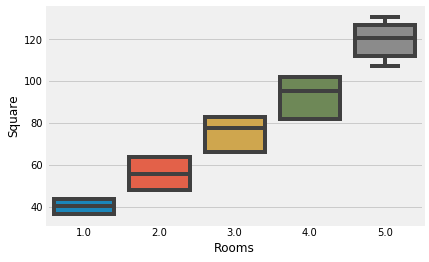

In [43]:
sns.boxplot(x=test['Rooms'],y=test['Square'])